In [3]:
import numpy as np
import chaospy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# benchmarks for test 1

In [4]:
# given mean and covariance
d = 4
mean_1 = np.array([1, 3, 5, 7])
cov_1 = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)


dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

In [6]:
# model function
a = np.array([1,1,1,1])

def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result


In [7]:
# sobol indices
S_i = []
for i in range(d):
    S_i_i = a[0]**2*cov_1[i,i]/np.trace(np.power(a,2)*cov_1)
    S_i.append(S_i_i)

S_i = np.hstack(S_i)
# for plot convinence
S_i = np.tile(S_i, (len(alp),1))
                       
print(S_i)

[[0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 0.16666667 0.2962963  0.46296296]
 [0.07407407 

In [9]:
# inverse error function
phi_inv = norm.ppf(alp)

In [11]:
# q_2: PDF of the out put Y(Eq.30)
q_2 = []
for a in range(len(alp)):
    q_2_a = []
    for i in range(d):
        q_2_i = cov_1[i,i] + phi_inv[a]**2*(np.sqrt(np.trace(cov_1))-np.sqrt(sum(cov_1[j,j] for j in range(d) if j != i)))**2
        q_2_a.append(q_2_i)
    q_2.append(q_2_a)
    
q_2 = np.vstack(q_2).reshape((len(alp),d))

In [12]:
# Q_2: quantile based sensitivit measure 2.(Eq.14)
Q_2 = []
for a in range(len(alp)):
    Q_2_a = []
    for i in range(d):
        Q_2_i = q_2[a,i]/sum(q_2[a])
        Q_2_a.append(Q_2_i)
    Q_2.append(Q_2_a)

Q_2 = np.hstack(Q_2).reshape((len(alp),d))

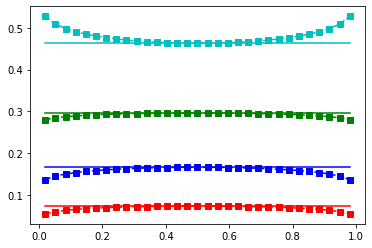

In [13]:
plt.plot(alp,Q_2[:,0],'rs--',alp,Q_2[:,1],'bs--',alp,Q_2[:,2],'gs--',alp,Q_2[:,3],'cs--')
plt.plot(alp,S_i[:,0],'r-',alp,S_i[:,1],'b-',alp,S_i[:,2],'g-',alp,S_i[:,3],'c-')

# MCS_quantile function

In [87]:
def MCS_quantile(alp,N,miu,sd,dist_type):
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp,dist_type)
    Q1_alp, Q2_alp = _nomalized_quantile_based_measures(N,M,dim,alp,dist_type)
    
    return q1_alp, q2_alp, Q1_alp, Q2_alp


def _quantile_based_measures(N,M,dim,alp,dist_type):
    # shape(1, 4, 1, 64)
    delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    q1_alp=np.zeros((len(alp),dim))
    q2_alp=np.zeros((len(alp),dim))
    
    qy_alp1 = _unconditional_q_Y(N,M,dim,alp,dist_type)
    qy_alp2 = _conditional_q_Y(N,M,dim,alp,dist_type)
    
    for i in range(dim):
        for pp in range(len(alp)):
            delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
            q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
            q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2
            
    return q1_alp, q2_alp


def _nomalized_quantile_based_measures(N,M,dim,alp,dist_type):
    # shape(1, 31)
    q1=np.zeros(len(alp))
    q2=np.zeros(len(alp))

    Q1_alp=np.zeros((len(alp),dim))
    Q2_alp=np.zeros((len(alp),dim))
    
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp,dist_type)
    
    for pp in range(len(alp)):
        q1[pp]=np.sum(q1_alp[pp,:])
        q2[pp]=np.sum(q2_alp[pp,:])
        for i in range(dim):
            Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
            Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]
    
    return Q1_alp, Q2_alp


def _unconditional_q_Y(N,M,dim, alp,dist_type):
    A,B  = _get_samples(N, M, dim, dist_type)
    # values of outputs
    Y1 = objfun(A)
    # reorder in ascending order
    y1 = np.sort(Y1)
    
    # q_Y(alp)
    q_index = (np.floor(alp*N)-1).astype(int)
    qy_alp1 = y1[q_index]
    
    return qy_alp1 


def _conditional_q_Y(N,M,dim,alp,dist_type):
    A,B  = _get_samples(N, M, dim, dist_type)
    
    # conditional sample matrix C,with shape(64, 4, 8192, 4)
    C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

    for i in range(dim):
        for j in range(M):
            C[j,i] = A
            C[j,i,:,i] = B[j, i]  
    # values of conditional outputs
    # shape(8192, 4, 8192, 1)
    Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    
    # shape(1, 4, 31, 64)
    qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    
    for i in range(dim):
        for j in range(M):
            Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
            Y2[j,i].sort(axis=0)
            y2[j,i] = Y2[j,i] # reorder in ascending order
            for pp in range(len(alp)):
                qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)
    
    return qy_alp2


def _get_samples(N, M, dim, dist_type):
    
    A = np.zeros((N,dim))
    B = np.zeros((M,dim))
    X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
    X02 = cp.generate_samples(order=M, domain=dim, rule="S").T
    
    if dist_type=="Normal":
        A = norm.ppf(X01,loc=miu, scale=sd)
        B = norm.ppf(X02,loc=miu, scale=sd)
    elif dist_type=="Exponential":
        A = expon.ppf(X01)
        B = expon.ppf(X02)
    elif dist_type=="Uniform":
        A = uniform.ppf(X01,loc=-np.pi,scale=2*np.pi)
        B = uniform.ppf(X02,loc=-np.pi,scale=2*np.pi)

    return A,B

# Test 1: Linear function

In [88]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

# mean for normal distribution
miu = np.array([1,3,5,7])

# standard deviation for normal distribution
sd = np.array([1,1.5,2,2.5])

# objective function
a = [1,1,1,1]
def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

# dimension of inputs
dim = np.size(miu) # 4

# distribution type
dist_type="Normal"

In [89]:
q1_alp, q2_alp, Q1_alp, Q2_alp=MCS_quantile(alp,N,miu,sd,dist_type)

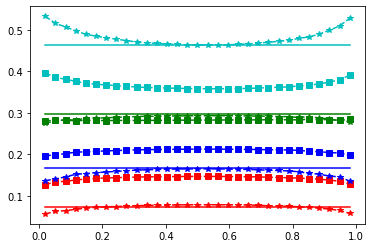

In [90]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

plt.plot(alp,S_i[:,0],'r-',alp,S_i[:,1],'b-',alp,S_i[:,2],'g-',alp,S_i[:,3],'c-')

# Test 2: $Y=x_1+x_2+x_3-x_4$


In [91]:
from scipy.stats import expon

# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

# objective function
a = [1,-1,1,-1]
def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

# dimension of inputs
dim = np.size(a) # 4

# distribution type
dist_type="Exponential"

In [93]:
q1_alp, q2_alp, Q1_alp, Q2_alp=MCS_quantile(alp,N,miu,sd,dist_type)

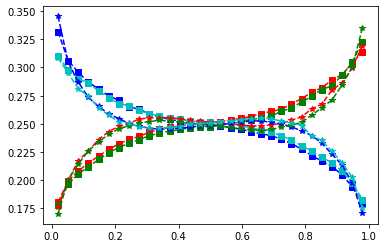

In [94]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

# plt.plot(alp,S_i[:,0],'r-',alp,S_i[:,1],'b-',alp,S_i[:,2],'g-',alp,S_i[:,3],'c-')

# Test 3: $Y=sin(x_1)+7(sin x_2)^2+0.1x_3^4sin(x_1)$

In [97]:
from scipy.stats import uniform

# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

# objective function
def objfun(x):

    result = np.sin(x[:,0]) + 7 * np.sin(x[:,1])**2 + 0.1 * x[:,2]**4*np.sin(x[:,0])
    
    return result


# dimension of inputs
dim = 3 

# distribution type
dist_type="Uniform"

## upper，lowerbound？

In [98]:
q1_alp, q2_alp, Q1_alp, Q2_alp=MCS_quantile(alp,N,miu,sd,dist_type)

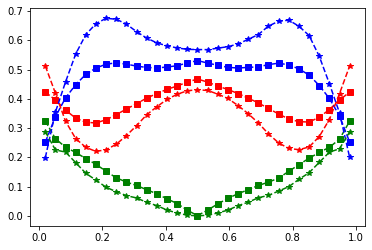

In [100]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--')

# Test 4: $Y=x_1 x_2+x_3 x_4$

In [ ]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

miu = np.array([0, 0, 250, 400])

cov = np.array(
    [
        [16, 2.4, 0, 0],
        [2.4, 4, 0, 0],
        [0, 0, 40000, -18000],
        [0, 0, -18000, 90000],
    ],
)


# objective function
def objfun(x):

    result = x[:,0]*x[:,1]+x[:,2]*x[:,3]
    
    return result


# dimension of inputs
dim = np.size(miu)

# distribution type
dist_type="Uniform"